In [1]:
import time 
start_time = time.time()

import evaluate # self-written
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from sklearn import tree, metrics, ensemble, model_selection

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_theme(style="darkgrid")

In [2]:
data = pd.read_csv('data/data_after_LDA.csv')

num_features = data.shape[1] - 1
num_classes = 2

In [3]:
data.dtypes

topic_0            float64
topic_1            float64
topic_2            float64
topic_3            float64
topic_4            float64
nlikes             float64
nreplies           float64
nretweets          float64
tweets             float64
following          float64
followers          float64
likes              float64
media              float64
day                float64
reply_to           float64
url                float64
join_time          float64
day_after          float64
tweet_length       float64
tweet_sentiment    float64
bio_sentiment      float64
first_person       float64
second_person      float64
third_person       float64
label                int64
dtype: object

In [4]:
from sklearn import tree, metrics, ensemble, model_selection

x, y = data.iloc[:,:-1], data.iloc[:,-1]
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 1016)

# Single Decision Tree

Optimal max_tree_depth and it's mean cross validation score(AUC):  5 0.813849432759913


<AxesSubplot:xlabel='max_tree_depth', ylabel='mean cross-val score(AUC)'>

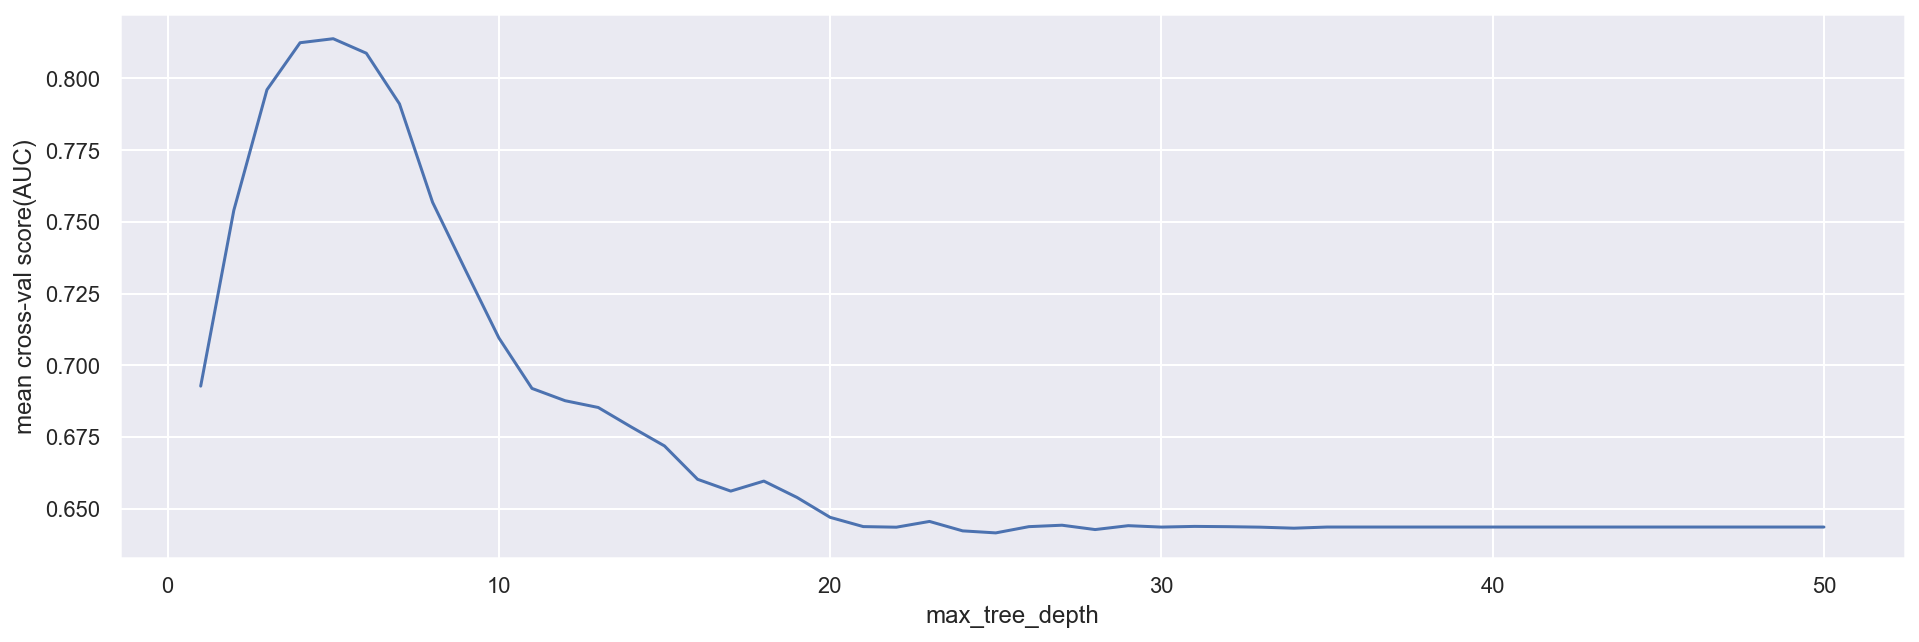

In [5]:
cv_score = []
num_CV = 50

for i in range(num_CV):
    dt_clf = tree.DecisionTreeClassifier(max_depth = i + 1, random_state = 1016, class_weight = 'balanced')
    score = model_selection.cross_val_score(dt_clf, x_train, y_train, scoring = "roc_auc", cv = 10).mean()
    cv_score.append(score)
cv_score = np.array(cv_score)

optimal_depth = (np.argmax(cv_score) + 1)
print("Optimal max_tree_depth and it's mean cross validation score(AUC): ", optimal_depth, cv_score[np.argmax(cv_score)])

plt.figure(figsize=(16,5))
sns.lineplot(data = pd.DataFrame({
    'max_tree_depth': range(1, num_CV + 1),
    'mean cross-val score(AUC)': cv_score
    }), x = "max_tree_depth", y = 'mean cross-val score(AUC)',
)

Optimal min_samples_split and it's mean cross validation score(AUC):  2 0.813849432759913
Optimal min_samples_leaf and it's mean cross validation score(AUC):  10 0.8160021737835745


<AxesSubplot:xlabel='min_samples_leaf', ylabel='mean cross-val score(AUC)'>

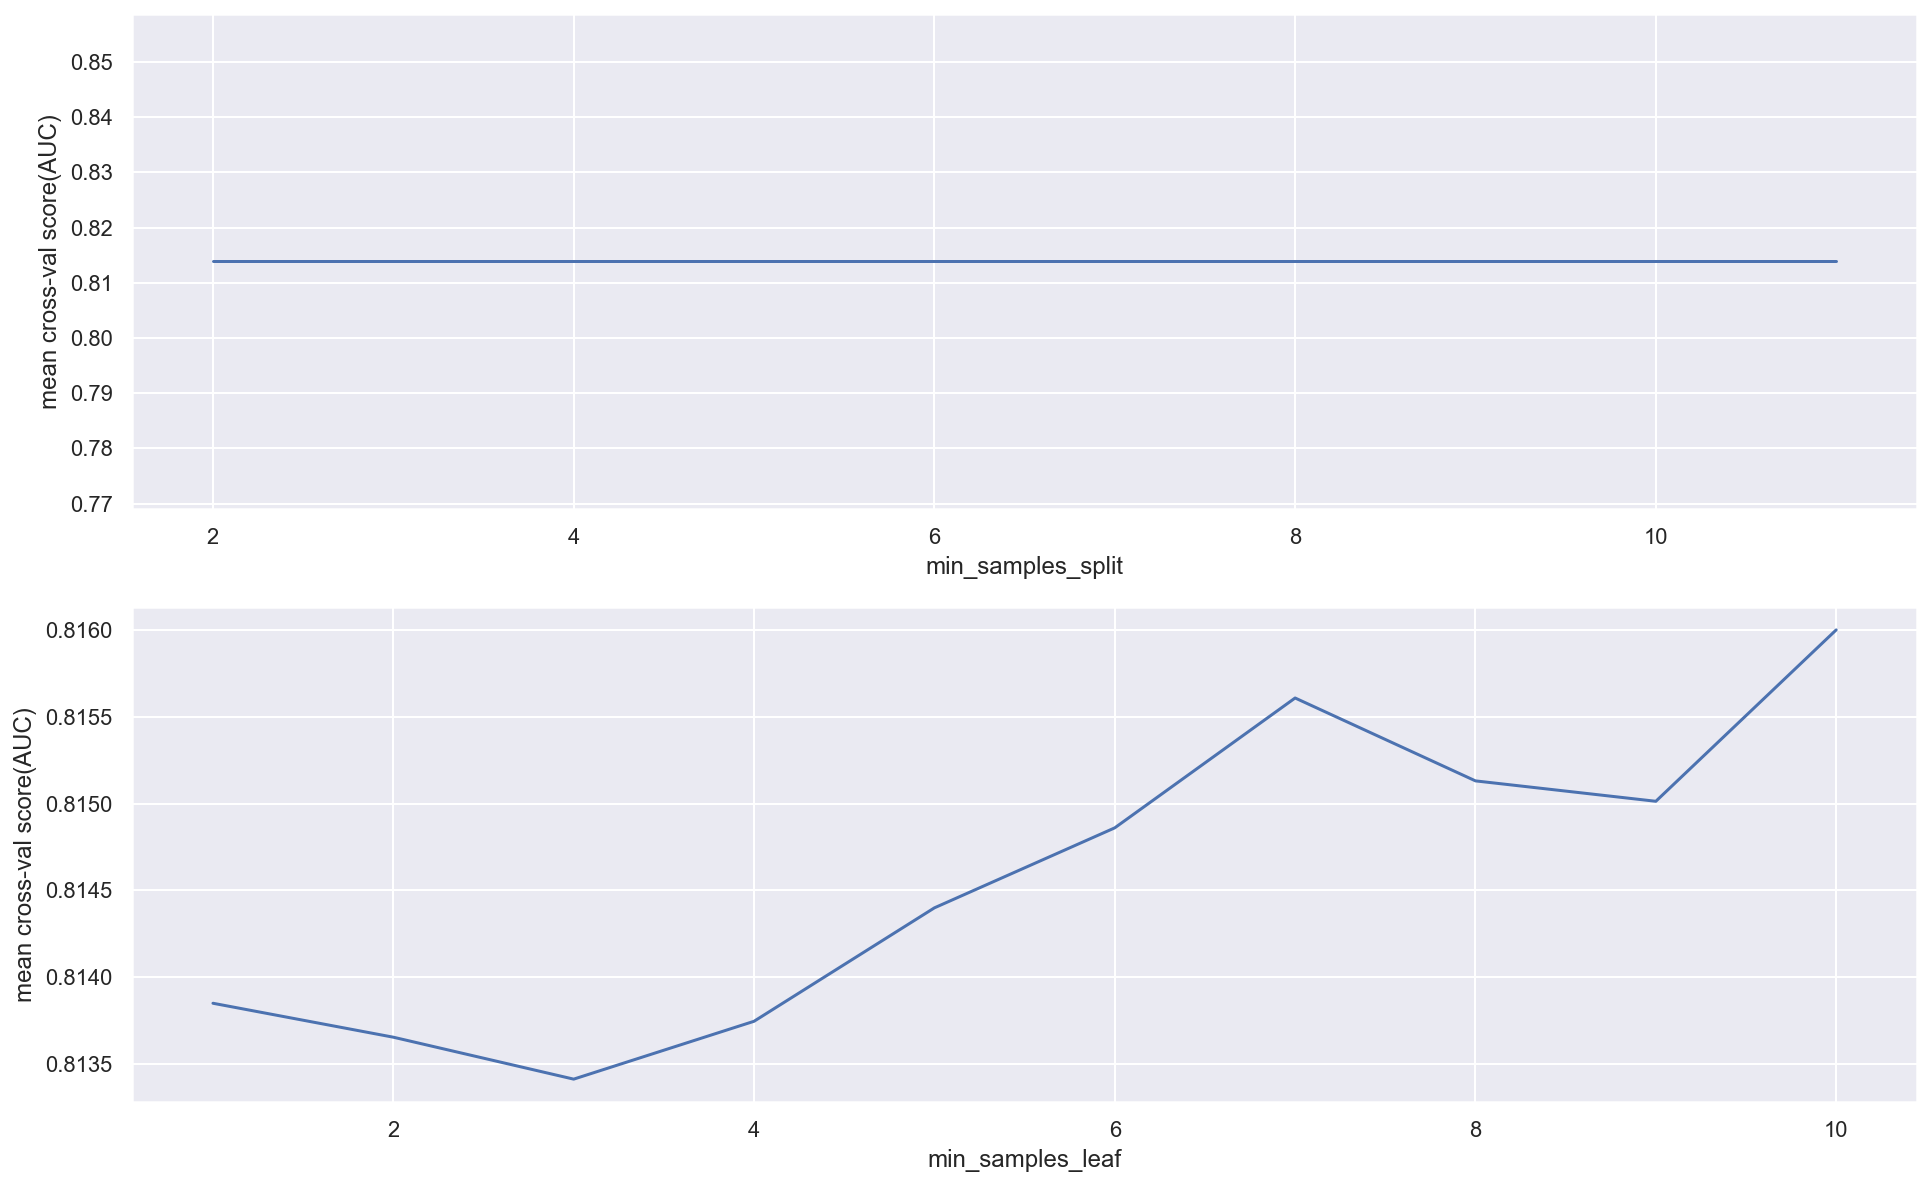

In [6]:
plt.figure(figsize = [16,10])
cv_score = []
num_CV = 10

# Tuning min_samples_split
for i in range(num_CV):
    dt_clf = tree.DecisionTreeClassifier(
        max_depth = optimal_depth, 
        min_samples_split = i + 2, 
        random_state = 1016, 
        class_weight = 'balanced'
    )
    score = model_selection.cross_val_score(dt_clf, x_train, y_train, scoring = "roc_auc", cv = 10).mean()
    cv_score.append(score)
cv_score = np.array(cv_score)

optimal_split = np.argmax(cv_score) + 2
print("Optimal min_samples_split and it's mean cross validation score(AUC): ", optimal_split, cv_score[np.argmax(cv_score)])  

plt.subplot(2, 1, 1)
sns.lineplot(data = pd.DataFrame({
    'min_samples_split': range(2, num_CV + 2),
    'mean cross-val score(AUC)': cv_score
    }), x = "min_samples_split", y = 'mean cross-val score(AUC)',
)

cv_score = []
# Tuning min_samples_leaf
for i in range(num_CV):
    dt_clf = tree.DecisionTreeClassifier(
        max_depth = optimal_depth, 
        min_samples_split = optimal_split, 
        min_samples_leaf = i + 1,
        random_state = 1016, 
        class_weight = 'balanced'
    )
    score = model_selection.cross_val_score(dt_clf, x_train, y_train, scoring = "roc_auc", cv = 10).mean()
    cv_score.append(score)
cv_score = np.array(cv_score)

optimal_leaf = np.argmax(cv_score) + 1
print("Optimal min_samples_leaf and it's mean cross validation score(AUC): ", optimal_leaf, cv_score[np.argmax(cv_score)])  
plt.subplot(2, 1, 2)
sns.lineplot(data = pd.DataFrame({
    'min_samples_leaf': range(1, num_CV + 1),
    'mean cross-val score(AUC)': cv_score
    }), x = "min_samples_leaf", y = 'mean cross-val score(AUC)',
)

In [7]:
param_grid = {
    'max_depth': np.arange(1, 10),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10),
}

dt_clf = tree.DecisionTreeClassifier(random_state = 1016, class_weight = 'balanced')
GS = model_selection.GridSearchCV(dt_clf, param_grid, scoring = 'roc_auc', n_jobs = -1, cv = 10)
GS.fit(x_train, y_train) 

for k, v in GS.best_params_.items():
    print("Optimal {} = {}".format(k, v))

print("Best model's AUC score: {}".format(GS.best_score_))

KeyboardInterrupt: 

In [18]:
dt_clf = GS.best_estimator_
y_pred_proba = dt_clf.predict_proba(x_test)

y_pred = evaluate.threshold(y_pred_proba, y_test)['y_pred']
print(evaluate.performance(y_test, y_pred, y_pred_proba)['report'])


The evaluation report of classification is:
Confusion Matrix:
[[800 622]
 [ 43 383]]
Accuracy: 0.6401515151515151
Precision: 0.38109452736318405
Recall: 0.8990610328638498
F2 Score: 0.7069029162052417
AUC Score: 0.7308244686119529



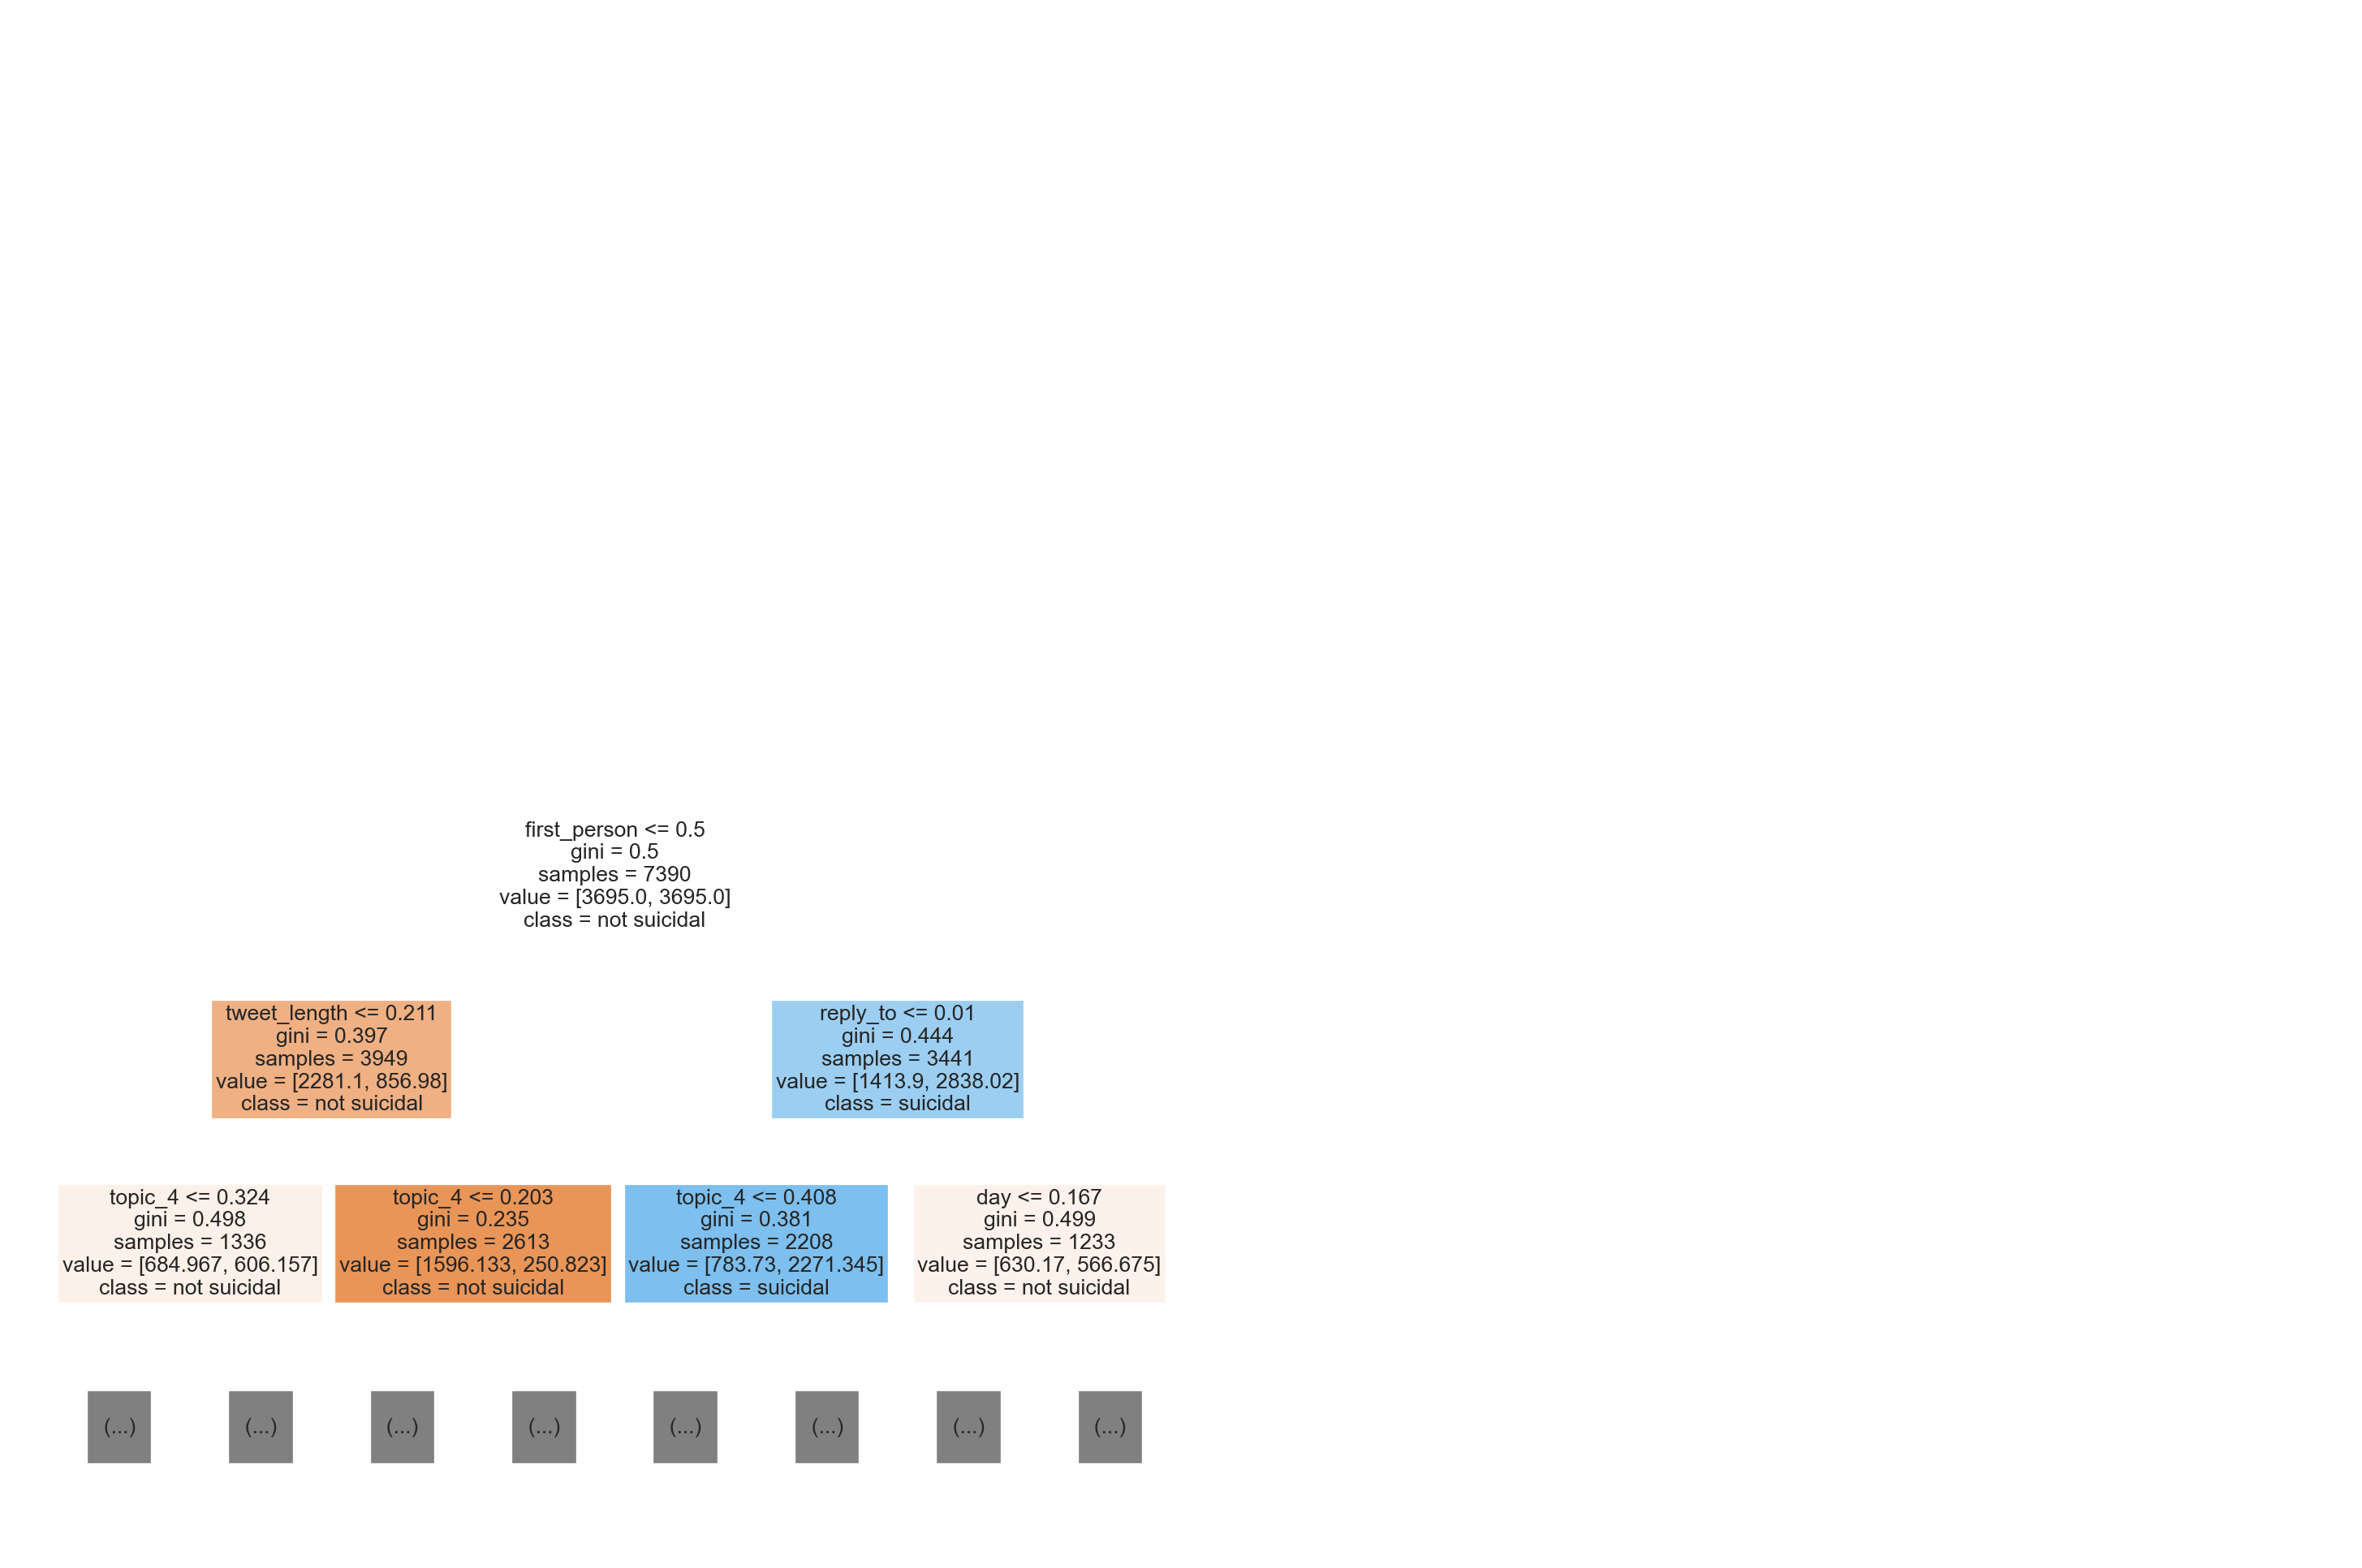

In [19]:
fig = plt.figure(dpi = 300)
tree.plot_tree(
    dt_clf, 
    max_depth = 2,
    feature_names = data.columns,  
    class_names = ['not suicidal', 'suicidal'],
    filled = True
)
fig.savefig("decistion_tree.png")

# Neural Network (Fully Connected)

train, test = model_selection.train_test_split(data, test_size = 0.2, random_state = 1016)

train, val = model_selection.train_test_split(train, test_size = 0.2, random_state = 1016)

print(len(train), 'train examples')

print(len(val), 'validation examples')

print(len(test), 'test examples')

train_ds = tf.data.Dataset.from_tensor_slices(
    (train.iloc[:,:-1].values, train.iloc[:,-1].values)
).shuffle(len(train)).batch(BATCHES)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val.iloc[:,:-1].values, val.iloc[:,-1].values)
).batch(BATCHES)

test_ds = tf.data.Dataset.from_tensor_slices(
    (test.iloc[:,:-1].values, test.iloc[:,-1].values)
).batch(BATCHES)

In [7]:
def create_model(dropout_rate=0.1, neurons=128):
    METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
    ]
    
    model = keras.Sequential([
        keras.layers.Input(shape = (24, )),
        keras.layers.Dense(neurons, activation='relu'),
        keras.layers.Dense(neurons, activation='relu'),
        keras.layers.Dense(neurons, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer = 'adam',
        loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
        metrics = METRICS
    )
    
    return model

In [12]:
batch_size = [32, 64, 128, 256]
epoch = [10, 20, 30]
dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
neurons = [32, 64, 128, 256]

total = len(data)
pos = np.count_nonzero(data.iloc[:,-1])
neg = total - pos

weight_for_0 = (1 / neg) * (total) / 2.0 
weight_for_1 = (1 / pos) * (total) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [67]:
model = scikeras.wrappers.KerasClassifier(
    model = create_model, 
    verbose = 1,
)

param_grid = dict(
    batch_size = batch_size,
    epochs = epoch,
    dropout_rate = dropout_rate,
    neurons = neurons,
    class_weight = [class_weight]
)

GS = model_selection.GridSearchCV(
    estimator = model, 
    param_grid = param_grid, 
    scoring = 'roc_auc',
    n_jobs = -1, 
    refit = False,
    verbose = 4,
    cv = 5,
)

GS.fit(x_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=KerasClassifier(model=<function create_model at 0x7fbf1aea3d40>),
             n_jobs=-1, param_grid={'epochs': [10, 20, 30]}, refit=False,
             scoring='roc_auc', verbose=4)

In [69]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_auc', 
    verbose = 1,
    patience = 3,
    mode = 'max',
    restore_best_weights = True
)

history = create_model(dropout_rate = GS.best_params_['dropout_rate'], neurons = GS.best_params_['neurons']).fit(
    x = x_train, y = y_train
    batch_size = GS.best_params_['batch_size'],
    validation_split = 0.2,
    epochs = GS.best_params_['epochs'],
    callbacks = [early_stopping],
    class_weight = class_weight
)

KeyError: 'dropout_rate'

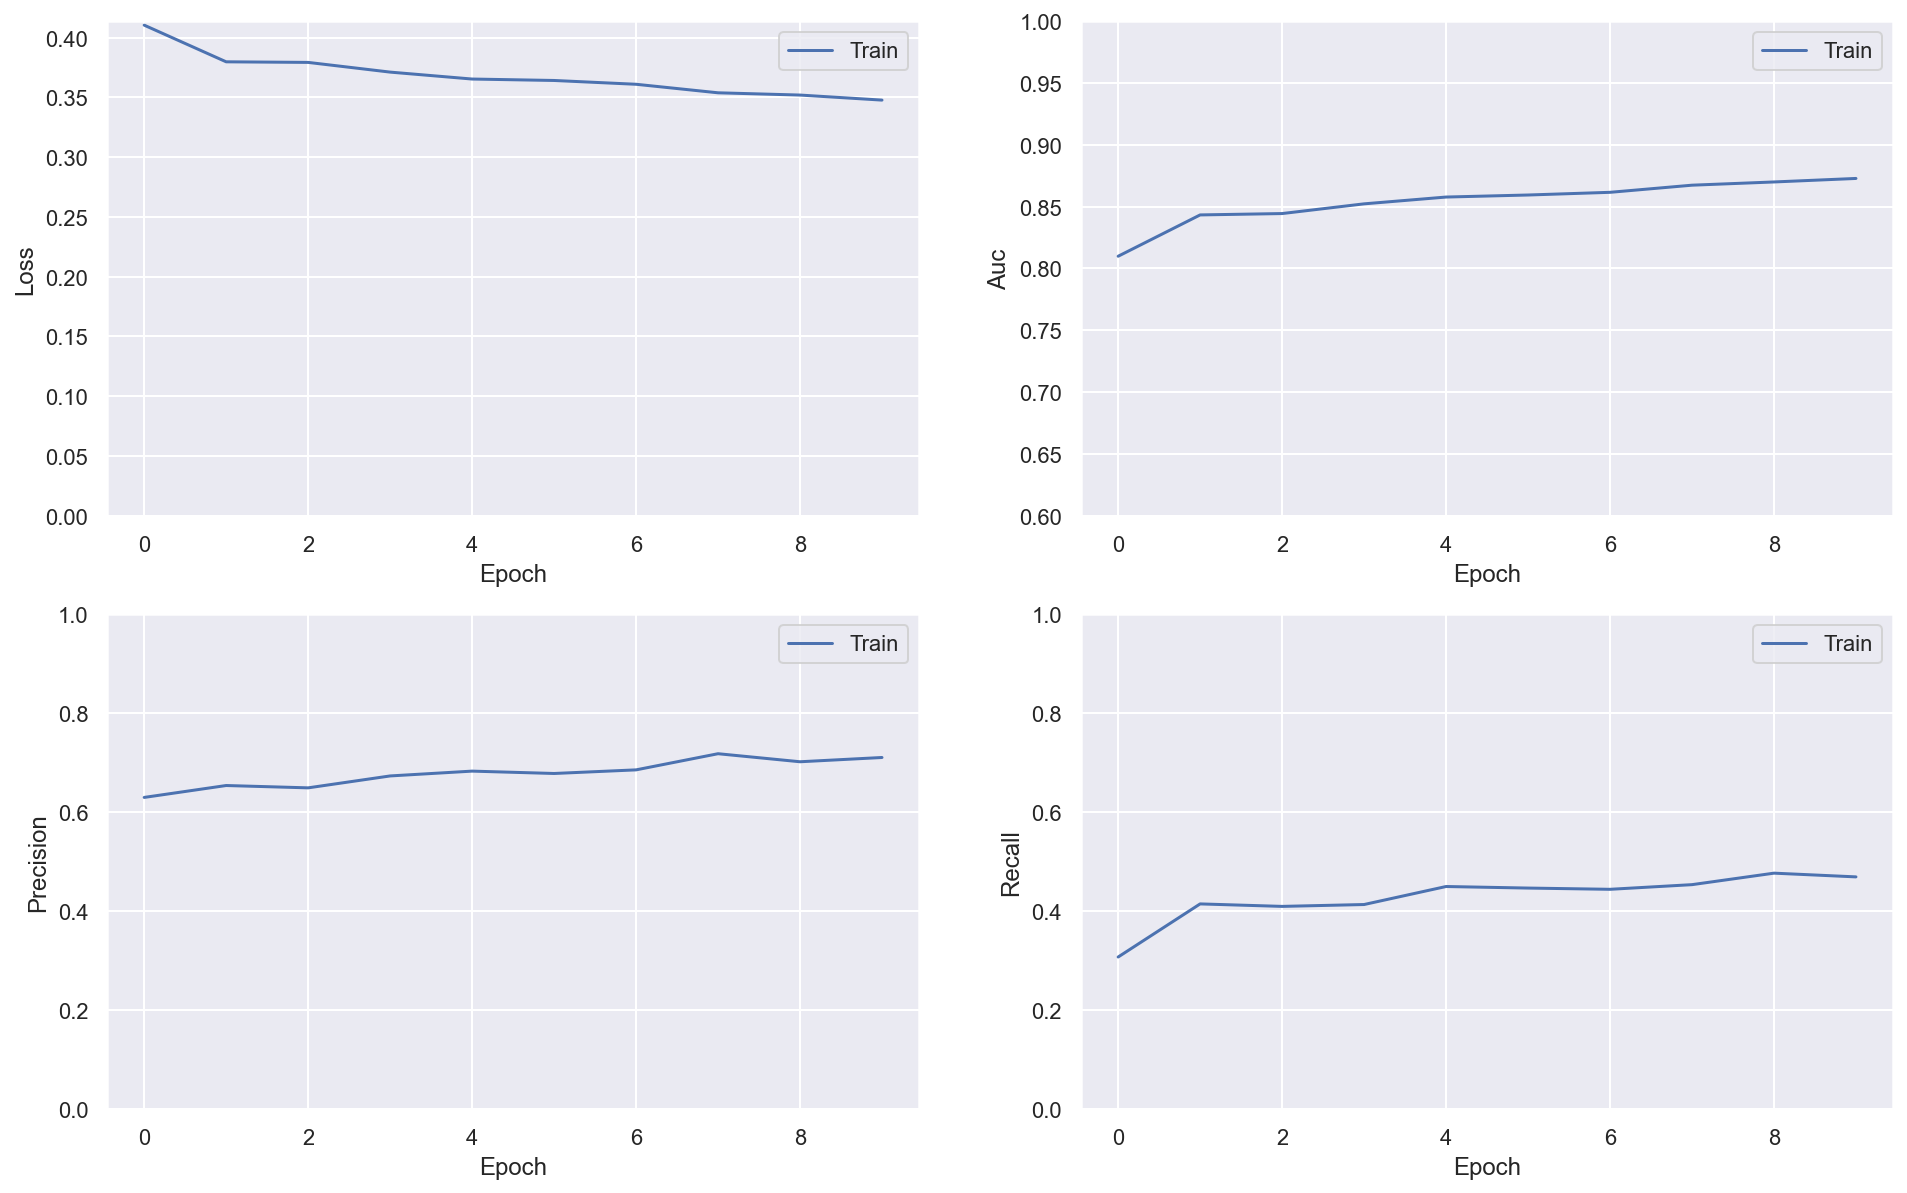

In [61]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
metrics = ['loss', 'auc', 'precision', 'recall']

plt.figure(figsize=(16, 10))
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2, 2, n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    # plt.plot(history.epoch, history.history['val_'+metric], color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.6,1])
    else:
        plt.ylim([0,1])
    plt.legend()

In [73]:
# result = model.evaluate(test_ds, batch_size = 32, verbose = 0)
y_pred_proba = dt_clf.predict_proba(x_test)

y_pred = evaluate.threshold(y_pred_proba, y_test)['y_pred']
print(evaluate.performance(y_test, y_pred, y_pred_proba)['report'])


The evaluation report of classification is:
Confusion Matrix:
[[800 622]
 [ 43 383]]
Accuracy: 0.6401515151515151
Precision: 0.38109452736318405
Recall: 0.8990610328638498
F2 Score: 0.7069029162052417
AUC Score: 0.7308244686119529



In [ ]:
end_time = time.time()

print("Time: {0:.2f}s".format(end_time - start_time))